# Extract data from .sol files

Use this if you are using the Wilkens function mode 2 to extract <a> loop (phase 0) and <c> loop (phase 1)densities

This workbook is an example of how the extractDataDir function can be used to extract physical paramaters from a folder a .sol files. 

This data frame is then manipulated for plotting data from a synchrotron experiment as an example.

## Import stuff

In [1]:
import pandas as pd
from src.cmwp_tools import extractDataDir
import matplotlib.pyplot as plt

## Extract data from solution files

This code extracts data from CMWP .sol files

In [82]:
calcLoop = False
data_df = extractDataDir('/home/rhys/Documents/CMWP-211102/2020_11_DESY/hyd/*.sol', calcLoop=calcLoop, wavelength=0.018505104)

Parsing 57 solution files...
Parsed 56 solution files succesfully                                                                    
"*** END" not present in 1                                                                     
Done!


## Pull out z and y values from filename

In [83]:
data_df[['f2', 'y', 'f4', 'zs']] = data_df['filename'].str.split('_',expand=True)               # Split by '_'
data_df[['z', 'no']] = data_df['zs'].str.split('.s',expand=True)                                # Split by '.s'
data_df.drop(['f2', 'filename', 'f4', 'zs', 'no'], axis=1, inplace=True)                        # Clear un-needed columns
data_df['y'] = pd.to_numeric(data_df['y'], downcast="float")
data_df['z'] = pd.to_numeric(data_df['z'], downcast="float")

# Rearrange to put y and z first
cols = data_df.columns.tolist()
data_df=data_df[cols[-2:] + cols[:-2]]

In [84]:
# Print dataframe
data_df

,y,z,a1,a1_1,a2,a2_1,a_err,a_lat,b,b_1,...,e,e_1,e_1_neg,e_1_pos,e_neg,e_pos,peak_int,peak_names,peak_pos,rhoIGS
0,20.695,14.919,-0.5332,2.6411,-0.307,1.0058,0.000195,3.237281,364.943,1.0,...,0.183532,25.501900,17.851330,10.940315,0.035055,0.060198,"[453.834, 3114.93, 1801.75, 470.581, 614.216, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77944, 4.10608, 4.30165, 5.58192, 6.54968, ...",0.0
1,20.695,14.921,-0.5332,2.6411,-0.307,1.0058,0.000173,3.238030,235.263,1.0,...,0.296333,3.288720,2.880919,1.262868,0.121793,0.164761,"[613.416, 3615.17, 2189.24, 658.788, 898.479, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77864, 4.10613, 4.3007, 5.58149, 6.54997, 7...",0.0
2,20.695,14.923,-0.5332,2.6411,-0.307,1.0058,0.000165,3.237833,252.502,1.0,...,0.158031,50.000000,28.700000,20.000000,0.058155,0.060684,"[601.963, 3342.96, 2015.57, 621.292, 931.503, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77894, 4.10595, 4.3006, 5.58198, 6.5509, 7....",0.0
3,20.695,14.925,-0.5332,2.6411,-0.307,1.0058,0.000163,3.237687,336.733,1.0,...,0.145442,50.000000,20.300000,19.700000,0.044942,0.058031,"[722.936, 3276.79, 1902.53, 657.49, 908.007, 1...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77941, 4.10579, 4.30077, 5.58218, 6.55122, ...",0.0
4,20.695,14.927,-0.5332,2.6411,-0.307,1.0058,0.000166,3.237468,267.692,1.0,...,0.103971,3.700950,3.027377,1.461875,0.033167,0.041900,"[658.676, 3143.52, 2037.61, 683.087, 920.779, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77939, 4.10577, 4.30124, 5.58233, 6.55086, ...",0.0
5,20.695,14.929,-0.5332,2.6411,-0.307,1.0058,0.000186,3.237306,274.336,1.0,...,0.061915,14.671200,10.328525,5.604398,0.018884,0.027614,"[631.894, 3298.28, 2024.1, 634.264, 843.847, 1...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77943, 4.10562, 4.301, 5.58229, 6.55104, 7....",0.0
6,20.695,14.931,-0.5332,2.6411,-0.307,1.0058,0.000189,3.237238,241.408,1.0,...,0.051155,10.776400,5.592952,4.224349,0.014068,0.015909,"[569.159, 3614.47, 2204.54, 593.62, 813.516, 1...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77978, 4.10539, 4.30075, 5.58241, 6.55135, ...",0.0
7,20.695,14.933,-0.5332,2.6411,-0.307,1.0058,0.000179,3.237328,283.623,1.0,...,0.068130,13.867600,12.258958,4.853660,0.013149,0.034814,"[505.198, 3915.34, 2386.87, 543.737, 756.621, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77989, 4.10528, 4.30083, 5.58271, 6.55148, ...",0.0
8,20.695,14.935,-0.5332,2.6411,-0.307,1.0058,0.000147,3.237362,240.821,1.0,...,0.047779,7.653930,4.944439,3.030956,0.011371,0.021548,"[481.649, 3965.24, 2230.79, 457.202, 623.305, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.78024, 4.10549, 4.30137, 5.58314, 6.55145, ...",0.0
9,20.695,14.937,-0.5332,2.6411,-0.307,1.0058,0.000138,3.237350,209.517,1.0,...,0.058095,4.979040,2.220652,1.971700,0.012142,0.019694,"[449.792, 3482.18, 2147.42, 435.677, 515.643, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.7804, 4.10519, 4.3017, 5.58335, 6.55141, 7....",0.0


## Calculate depth from edge

This takes a list of all y positions (calculated from the data list above) 
and a list of the corresponsing z positions at the edge of the sample, 
to make a new column called 'depth', which is the distance of the pattern away from the sample edge in microns

In [85]:
# These are the unique y positions
data_df['y'] = pd.to_numeric(data_df['y'], downcast="float")
unique = data_df['y'].unique()
print(unique)

[20.695 21.195 21.695]


In [86]:
##########################################
# Here, define the edge (z value) for each y
##########################################

edges = [14.918, 14.918, 14.919]

if len(unique) != len(edges):
    raise Exception('Unique and edges should be the same length')
print(edges)

[14.918, 14.918, 14.919]


In [87]:
data_df.insert(0, 'depth', data_df['y'])
data_df['depth'].replace(to_replace=unique, value=edges, inplace=True)
data_df['depth'] = data_df['z'] - data_df['depth']
data_df['depth'] = np.round(data_df['depth'] * 1000,1)

In [88]:
data_df

,depth,y,z,a1,a1_1,a2,a2_1,a_err,a_lat,b,...,e,e_1,e_1_neg,e_1_pos,e_neg,e_pos,peak_int,peak_names,peak_pos,rhoIGS
0,1.0,20.695,14.919,-0.5332,2.6411,-0.307,1.0058,0.000195,3.237281,364.943,...,0.183532,25.501900,17.851330,10.940315,0.035055,0.060198,"[453.834, 3114.93, 1801.75, 470.581, 614.216, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77944, 4.10608, 4.30165, 5.58192, 6.54968, ...",0.0
1,3.0,20.695,14.921,-0.5332,2.6411,-0.307,1.0058,0.000173,3.238030,235.263,...,0.296333,3.288720,2.880919,1.262868,0.121793,0.164761,"[613.416, 3615.17, 2189.24, 658.788, 898.479, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77864, 4.10613, 4.3007, 5.58149, 6.54997, 7...",0.0
2,5.0,20.695,14.923,-0.5332,2.6411,-0.307,1.0058,0.000165,3.237833,252.502,...,0.158031,50.000000,28.700000,20.000000,0.058155,0.060684,"[601.963, 3342.96, 2015.57, 621.292, 931.503, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77894, 4.10595, 4.3006, 5.58198, 6.5509, 7....",0.0
3,7.0,20.695,14.925,-0.5332,2.6411,-0.307,1.0058,0.000163,3.237687,336.733,...,0.145442,50.000000,20.300000,19.700000,0.044942,0.058031,"[722.936, 3276.79, 1902.53, 657.49, 908.007, 1...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77941, 4.10579, 4.30077, 5.58218, 6.55122, ...",0.0
4,9.0,20.695,14.927,-0.5332,2.6411,-0.307,1.0058,0.000166,3.237468,267.692,...,0.103971,3.700950,3.027377,1.461875,0.033167,0.041900,"[658.676, 3143.52, 2037.61, 683.087, 920.779, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77939, 4.10577, 4.30124, 5.58233, 6.55086, ...",0.0
5,11.0,20.695,14.929,-0.5332,2.6411,-0.307,1.0058,0.000186,3.237306,274.336,...,0.061915,14.671200,10.328525,5.604398,0.018884,0.027614,"[631.894, 3298.28, 2024.1, 634.264, 843.847, 1...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77943, 4.10562, 4.301, 5.58229, 6.55104, 7....",0.0
6,13.0,20.695,14.931,-0.5332,2.6411,-0.307,1.0058,0.000189,3.237238,241.408,...,0.051155,10.776400,5.592952,4.224349,0.014068,0.015909,"[569.159, 3614.47, 2204.54, 593.62, 813.516, 1...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77978, 4.10539, 4.30075, 5.58241, 6.55135, ...",0.0
7,15.0,20.695,14.933,-0.5332,2.6411,-0.307,1.0058,0.000179,3.237328,283.623,...,0.068130,13.867600,12.258958,4.853660,0.013149,0.034814,"[505.198, 3915.34, 2386.87, 543.737, 756.621, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.77989, 4.10528, 4.30083, 5.58271, 6.55148, ...",0.0
8,17.0,20.695,14.935,-0.5332,2.6411,-0.307,1.0058,0.000147,3.237362,240.821,...,0.047779,7.653930,4.944439,3.030956,0.011371,0.021548,"[481.649, 3965.24, 2230.79, 457.202, 623.305, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.78024, 4.10549, 4.30137, 5.58314, 6.55145, ...",0.0
9,19.0,20.695,14.937,-0.5332,2.6411,-0.307,1.0058,0.000138,3.237350,209.517,...,0.058095,4.979040,2.220652,1.971700,0.012142,0.019694,"[449.792, 3482.18, 2147.42, 435.677, 515.643, ...","[100, 002, 101, 102, 110, 013, 020, 112, 021, ...","[3.7804, 4.10519, 4.3017, 5.58335, 6.55141, 7....",0.0


## Plot

This plots dislocation density, <a> loop fraction, M paramater and lattice paramaters as a function of depth from sample edge

(46.758247895571735, 46.93802611695555)

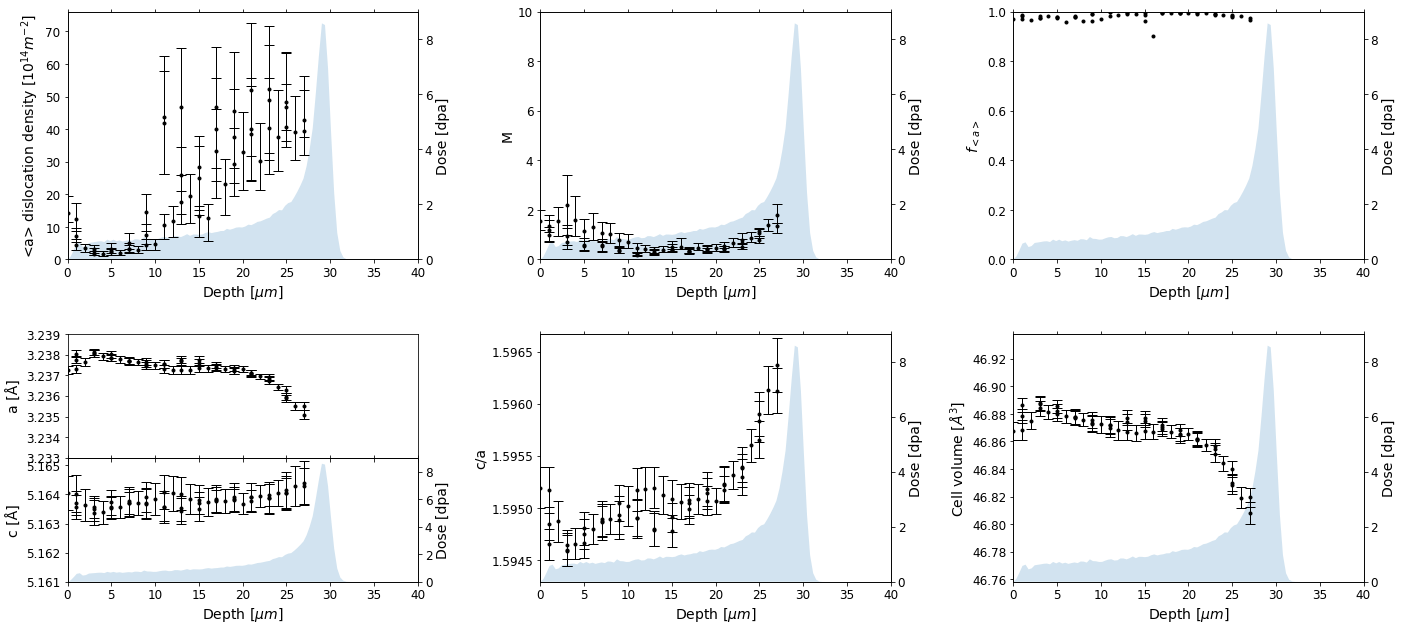

In [92]:
depth, dpa = np.loadtxt('data/srim.txt')

fig, axes = plt.subplots(2, 3, figsize=(20,9))
fig.subplots_adjust(left=0.06, right=0.96, top=0.98, bottom=0.1, hspace=0.3, wspace = 0.35)
axes = axes.ravel()

max_x = 40
x=data_df['depth']; a=data_df['a_lat']; c=data_df['c_lat']; a_err=data_df['a_err']; c_err=data_df['c_err'];

# Common settings for all axes
for sax in axes:
    sax.set_xlabel('Depth [${\mu}m$]', fontsize=14)
    sax.tick_params(axis='both', which='major', labelsize=12)
    sax.set_xlim(0, max_x)
    #sax.set_ylim(bottom=0)
    sax.xaxis.set_ticks_position('both')
    
    sec = sax.twinx()
    sec.fill(depth, np.array(dpa), alpha=0.2)
    sec.set_xlim(0, max_x)
    sec.set_ylim(0)
    sec.set_ylabel('Dose [dpa]', fontsize=14)
    sec.tick_params(axis='both', which='major', labelsize=12)
    
    sax.set_zorder(sec.get_zorder()+1)
    sax.patch.set_visible(False);

#### dislocation density

axes[0].errorbar(x=x, y=data_df['d'], yerr = [data_df['d_neg'],data_df['d_pos']],  marker='o',c='k',  ms=3, lw=0, elinewidth=1, capsize=5)
axes[0].set_ylabel('<a> dislocation density [$10^{14} m^{-2}$]', fontsize=14)
axes[0].set_ylim(0)

#### m

axes[1].errorbar(x=x, y=np.exp(2)*data_df['e'], yerr = np.exp(2)*np.array([data_df['e_neg'],data_df['e_pos']]), marker='o',c='k',  ms=3, lw=0, elinewidth=1, capsize=5)
axes[1].set_ylabel('M', fontsize=14)
axes[1].set_ylim(0, 10)

#### a loop fraction

axes[2].errorbar(x=x, y=data_df['d']/(data_df['d']+data_df['d_1']),   marker='o',c='k',  ms=3, lw=0, elinewidth=1, capsize=5)
axes[2].set_ylabel('$f_{<a>}$', fontsize=14)
axes[2].set_ylim(0, 1)

lim_defs=[np.round(np.min(a),3), np.round(np.max(a),3), np.round(np.min(c),3), np.round(np.max(c),3)]
ratio_a_to_c = (np.max(a)-np.min(a)+0.002)/((np.max(a)-np.min(a)+0.002)+(np.max(c)-np.min(c))+0.002)

#### c paramater

axes[3].errorbar(x=x, y=c, yerr=c_err, marker='o', c='k', ms=3, lw=0, elinewidth=1, capsize=5)
axes[3].set_ylabel('c [Å]', fontsize=14)
pos_orig = axes[3].get_position() # get the original position 
axes[3].set_position([pos_orig.x0, pos_orig.y0,  pos_orig.width, pos_orig.height*0.5])
axes[3].set_yticks(np.arange(lim_defs[2]-0.002, lim_defs[3]+0.0019, 0.001))

#### a paramater

ax4b = plt.axes([pos_orig.x0, pos_orig.y0 + pos_orig.height *0.5,  pos_orig.width, pos_orig.height*0.5] )
ax4b.errorbar(x=x, y=a, yerr=a_err, marker='o',c='k',  ms=3, lw=0, elinewidth=1, capsize=5)
ax4b.set_ylabel('a [Å]', fontsize=14)
ax4b.tick_params(axis='both', which='major', labelsize=12)
ax4b.xaxis.set_ticklabels([])
ax4b.set_xlim(0, max_x)
ax4b.set_ylim(lim_defs[0], lim_defs[1])
ax4b.set_yticks(np.arange(lim_defs[0]-0.002, lim_defs[1]+0.002, 0.001))

#### c/a

covera = np.array(c)/np.array(a)
axes[4].errorbar(x=x, y=covera, yerr=covera*np.sqrt((np.array(c_err)/np.array(c))**2+(np.array(a_err)/np.array(a))**2), marker='o',c='k',  ms=3, lw=0, elinewidth=1, capsize=5)
axes[4].set_ylabel('c/a', fontsize=14)
axes[4].set_ylim(np.min(np.array(c)/np.array(a))-0.0003, np.max(np.array(c)/np.array(a))+0.0003)

#### cell volume
vol = np.array(a)**2*np.sin(np.deg2rad(60))*np.array(c)
err_vol = vol * np.sqrt((np.array(c_err)/np.array(c))**2+2*(np.array(a_err)/np.array(a))**2)

axes[5].errorbar(x=x, y=vol, yerr=err_vol, c='k', marker='o', ms=3, lw=0, elinewidth=1, capsize=5)
axes[5].set_ylabel('Cell volume [$Å^3$]', fontsize=14)
axes[5].set_ylim(np.min(vol)-0.05, np.max(vol)+0.05)

#plt.savefig('/home/rhys/Dropbox (Research Group)/Postdoc/DESY/'+name+'_ellip'+str(ellip)+'.pdf', dpi=600)
#plt.show()